This notebook trains a word2vec embedding based on the SkipGram model with negative sampling according to https://jalammar.github.io/illustrated-word2vec/ and https://programmer.group/pytorch-implements-word2vec.html

In [1]:
import sys
import os
import joblib
from word2vec_util import TextCorpusProcess

In [2]:
# load text data
data_path = os.path.join('/notebooks/data/', 'img_prepared')
train_pklname = data_path + '_train.pkl'
train_data = joblib.load(train_pklname)
text_data = train_data['desc']

In [8]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.


True

In [9]:
# preprocess the text data
textCorpus = TextCorpusProcess(prod_descs=text_data)

In [10]:
# save the processed text data
text_dir = '/notebooks/data/'
os.makedirs(text_dir, exist_ok=True)
text_file = 'text_processed.pkl'
text_path = os.path.join(text_dir, text_file)
joblib.dump(textCorpus, text_path)

['/notebooks/data/text_processed.pkl']

In [7]:
# load the processed text data
text_dir = '/notebooks/data/'
text_file = 'text_processed.pkl'
text_path = os.path.join(text_dir, text_file)
textCorpus = joblib.load(text_path)

In [11]:
import torch
import numpy as np
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.tensorboard import SummaryWriter
import copy
from skip_gram_neg import SkipGramNeg, NegativeSamplingLoss
from word2vec_util import Word2VecDataloader
import os
import datetime


In [12]:
log_dir_path = os.path.join('/notebooks', 'runs')
save_dir_path = os.path.join('/notebooks', 'models')
os.makedirs(log_dir_path, exist_ok=True)
os.makedirs(save_dir_path, exist_ok=True)

In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# log dir for storing tensorboard files
log_dir = os.path.join(
    log_dir_path, datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))

writer = SummaryWriter(log_dir=log_dir)

# get the noise distribution for negative sampling
word_freqs = np.array(sorted(textCorpus.freq_dict.values(), reverse=True))
# prepare the multinomial distribution for negative sampling
unigram_dist = word_freqs/word_freqs.sum()
noise_dist = torch.from_numpy(
    unigram_dist**(0.75)/np.sum(unigram_dist**(0.75)))

# hyperparams
EMBED_DIM = 128
BATCH_SIZE = 16
NEG_SAMPLE_SIZE = 5
WINDOW_SIZE = 3
EPOCHS = 30
LR = 0.001

# instantiating the model
model = SkipGramNeg(
    vocab_size=textCorpus.vocab_size,
    embed_dim=EMBED_DIM,
    noise_dist=noise_dist,
    neg_sample_size=NEG_SAMPLE_SIZE,
    batch_size=BATCH_SIZE,
)
model = model.to(device)

# instantiating the dataloader
dataloader = Word2VecDataloader(
    prod_word_idx_lists=textCorpus.prod_word_idx_lists,
    batch_size=BATCH_SIZE,
    window_size=WINDOW_SIZE,
)

criterion = NegativeSamplingLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [16]:
epochs = EPOCHS
# an arbitrary high value for best_epoch_loss
best_epoch_loss = 100
best_model_wts = copy.deepcopy(model.state_dict())
for e in range(epochs):
    batch_count = 0
    running_loss = 0.0
    # get input, target batches
    for input_words, target_words in dataloader.generate_batch():
        inputs = torch.LongTensor(input_words)
        targets = torch.LongTensor(target_words)
        inputs, targets = inputs.to(device), targets.to(device)

        # input, outpt, and noise vectors
        input_vectors = model.forward_input(inputs)
        output_vectors = model.forward_output(targets)
        noise_vectors = model.generate_neg_samples(
            # len(input_words), exclude_words=None, device=device)
            len(input_words), exclude_words=target_words, device=device)

        # negative sampling loss
        loss = criterion(input_vectors, output_vectors, noise_vectors)
        running_loss += loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_count += 1
    exp_lr_scheduler.step()
    epoch_loss = running_loss / batch_count
    print(f'Epoch {e} / {epochs}')
    print(f'Epoch training loss: {epoch_loss}')
    writer.add_scalar(f'Training loss', epoch_loss, e)
    writer.flush()

    # deep copy the model
    if epoch_loss < best_epoch_loss:
        best_epoch_loss = epoch_loss
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(best_model_wts, os.path.join(
            save_dir_path, 'best_word2vec_ebedding_model.pt'))


Epoch 0 / 30
Epoch training loss: 18.275218963623047
Epoch 1 / 30
Epoch training loss: 7.9955902099609375
Epoch 2 / 30
Epoch training loss: 4.904534816741943
Epoch 3 / 30
Epoch training loss: 3.6742372512817383
Epoch 4 / 30
Epoch training loss: 3.006009817123413
Epoch 5 / 30
Epoch training loss: 2.579868793487549
Epoch 6 / 30
Epoch training loss: 2.284738779067993
Epoch 7 / 30
Epoch training loss: 2.026024580001831
Epoch 8 / 30
Epoch training loss: 1.986311912536621
Epoch 9 / 30
Epoch training loss: 1.9591854810714722
Epoch 10 / 30
Epoch training loss: 1.9340211153030396
Epoch 11 / 30
Epoch training loss: 1.910392165184021
Epoch 12 / 30
Epoch training loss: 1.8904653787612915
Epoch 13 / 30
Epoch training loss: 1.8703744411468506
Epoch 14 / 30
Epoch training loss: 1.8450475931167603
Epoch 15 / 30
Epoch training loss: 1.8412549495697021
Epoch 16 / 30
Epoch training loss: 1.8368033170700073
Epoch 17 / 30
Epoch training loss: 1.8389129638671875
Epoch 18 / 30
Epoch training loss: 1.83547699

In [17]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [18]:
# load saved model for visualization
model.load_state_dict(torch.load(os.path.join(
    save_dir_path, 'best_word2vec_ebedding_model.pt')))

<All keys matched successfully>

In [19]:
# getting embeddings from the embedding layer of our model, by name
embeddings = model.in_embed.weight.to('cpu').data.numpy()

In [20]:
viz_words = 300
tsne = TSNE()
embed_tsne = tsne.fit_transform(embeddings[:viz_words, :])

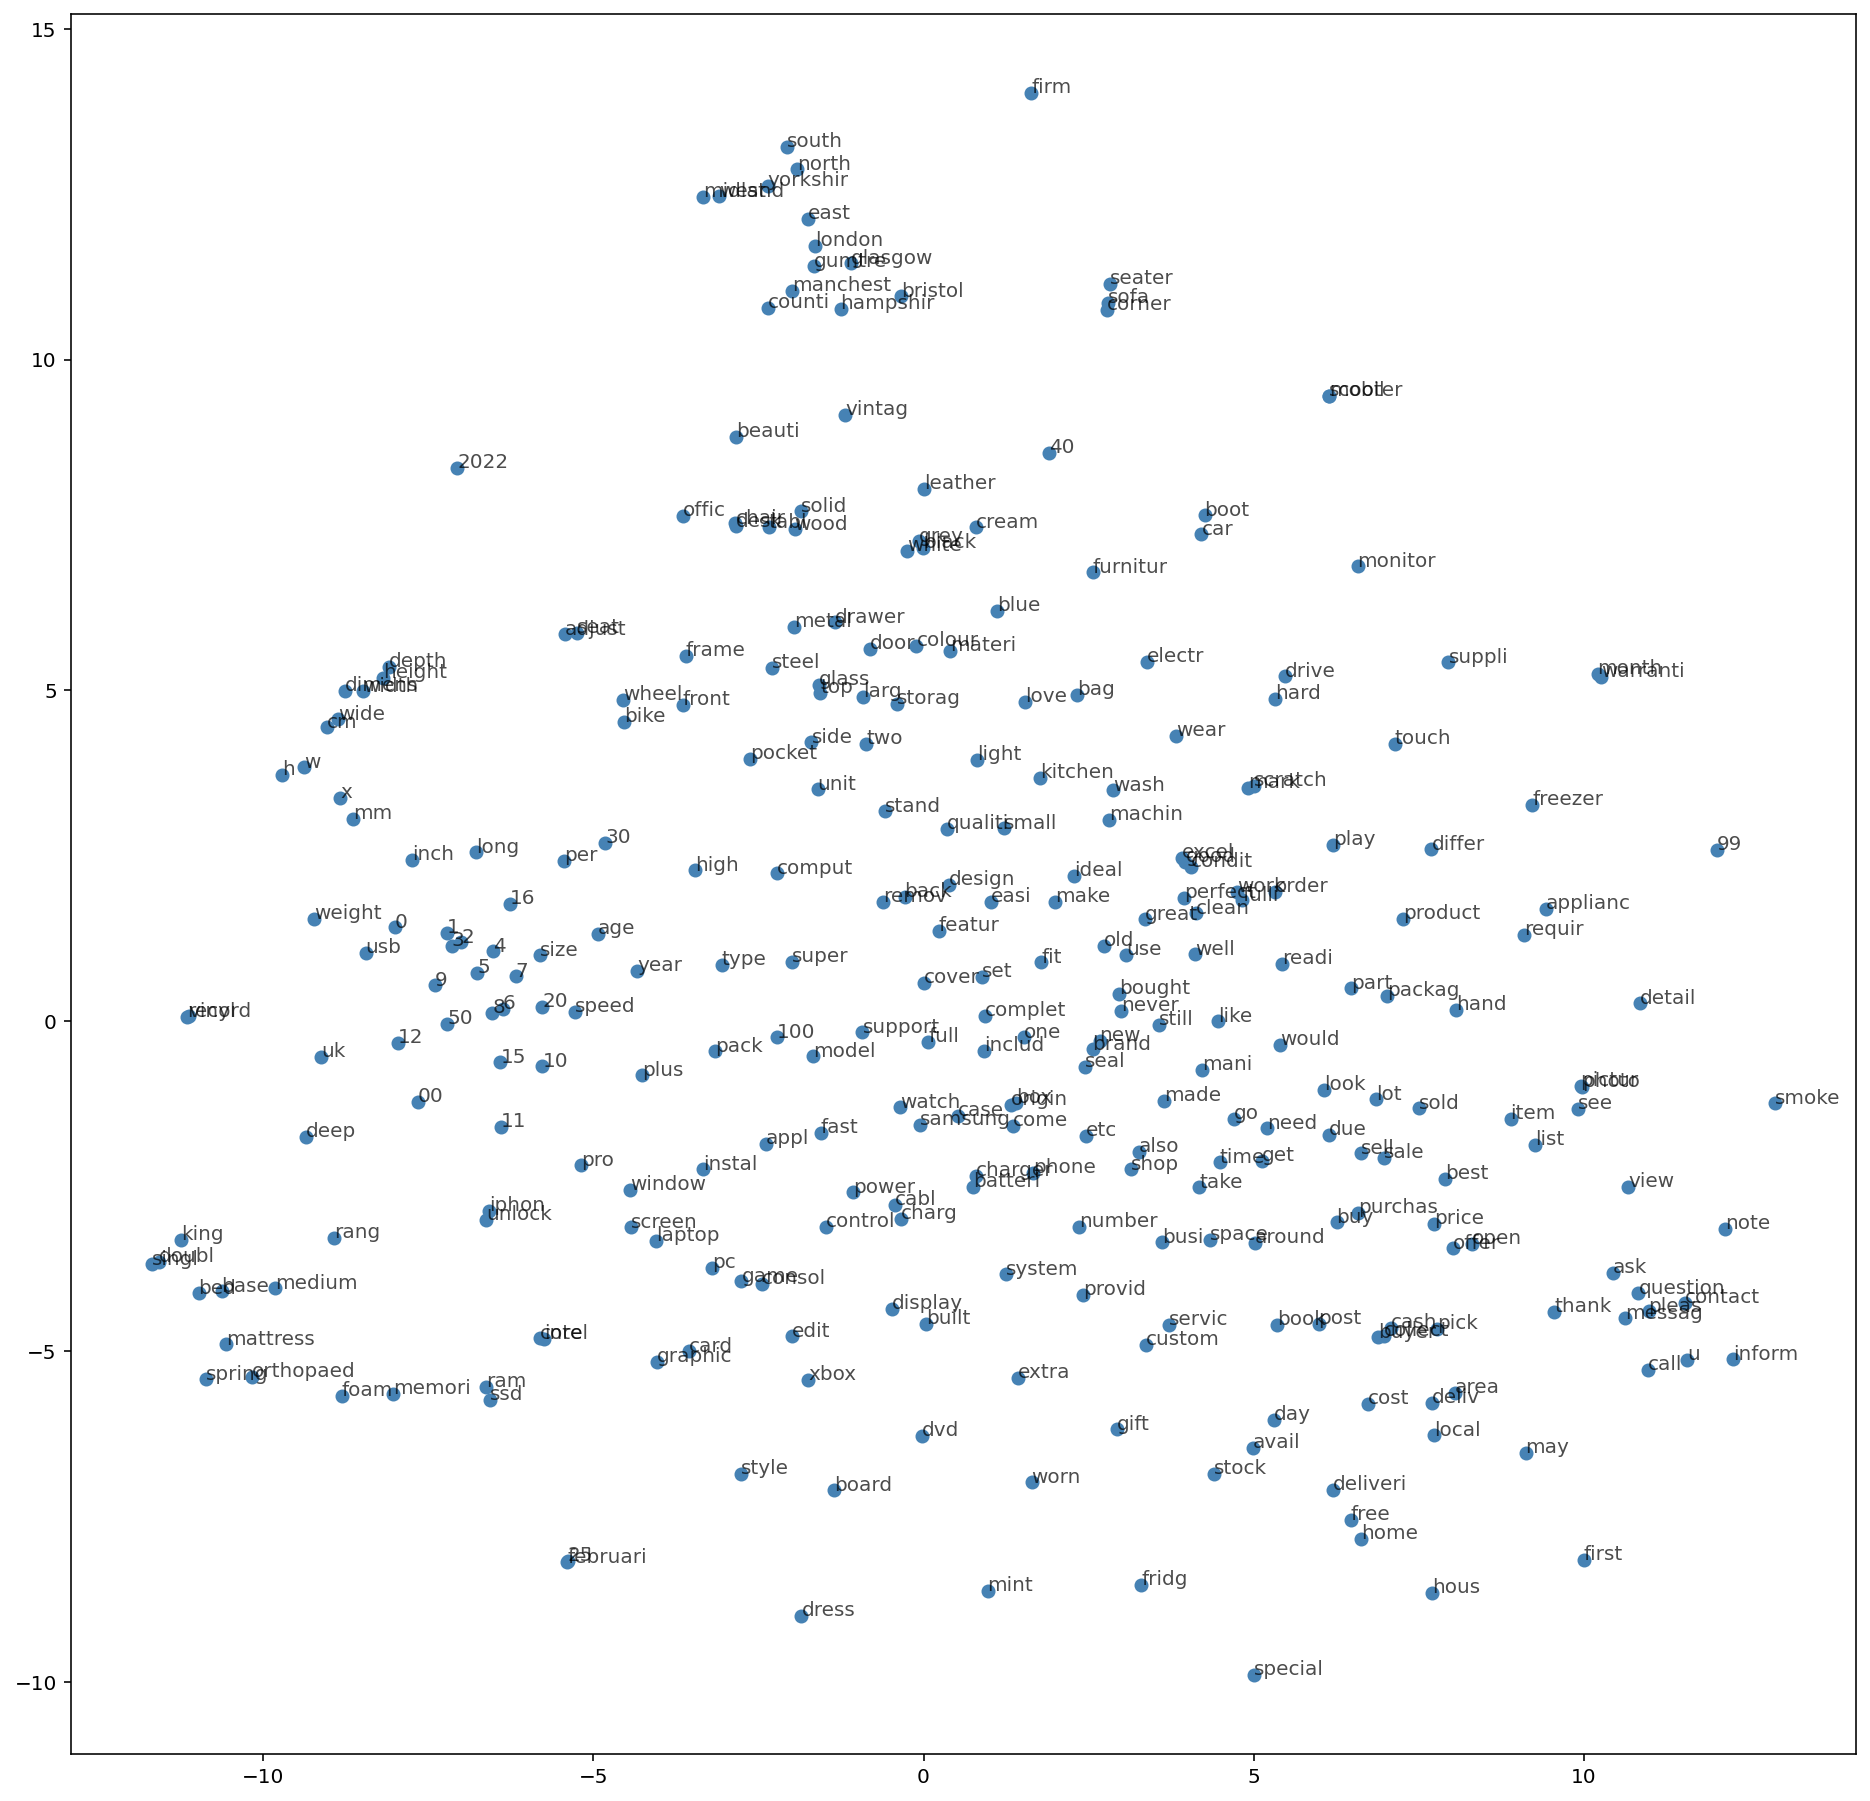

In [21]:
fig, ax = plt.subplots(figsize=(16, 16))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(
        textCorpus.idx_to_word[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)